<h1>AQI Prediction using SVR model</h1>

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math
import seaborn as sns

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

<h2>Importing the DataSet

In [2]:
data = pd.read_csv('AQI_data.csv')
data.shape

(355586, 43)

<h3>Droping any Null values and unnamed columns 

In [3]:
data.drop('Unnamed: 0', axis = 1, inplace = True)
data = data.dropna()
data.head()

,State Code,County Code,State,County,City,Date Local,NO2 Units,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,...,month,day,temperature_2m_max (°F),temperature_2m_min (°F),temperature_2m_mean (°F),precipitation_sum (mm),rain_sum (mm),snowfall_sum (cm),windgusts_10m_max (km/h),windspeed_10m_max (km/h)
0,6,13,California,Contra Costa,Bethel Island,2009-05-10,Parts per billion,4.043478,9.0,0,...,5.0,10.0,84.3,54.0,69.408330,0.0,0.0,0.0,0,18.1
1,17,31,Illinois,Cook,Cicero,2000-09-30,Parts per billion,18.125000,30.0,17,...,9.0,30.0,73.2,55.6,63.637493,0.0,0.0,0.0,0,24.6
2,6,73,California,San Diego,San Diego,2001-09-27,Parts per billion,25.090909,40.0,23,...,9.0,27.0,75.6,64.6,69.529160,0.0,0.0,0.0,0,15.2
3,6,13,California,Contra Costa,Bethel Island,2009-03-11,Parts per billion,8.476190,20.0,20,...,3.0,11.0,59.4,39.0,48.216670,0.0,0.0,0.0,0,7.5
4,6,83,California,Santa Barbara,Vandenberg Air Force Base,2006-10-12,Parts per billion,0.739130,4.0,17,...,10.0,12.0,65.7,53.4,58.512497,2.9,2.9,0.0,0,12.7


<h4>Reaaranging the dataframe chronologically, since we have a time series data and we are trying to predict how AQI changes over time, so the data should be chronologinal, otherwise the model will not reflect how AQI changes over time

In [4]:
data = data.sort_values(by='Date Local', ascending=True)

In [5]:
data.shape

(355586, 42)

In [6]:
data.head()

,State Code,County Code,State,County,City,Date Local,NO2 Units,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,...,month,day,temperature_2m_max (°F),temperature_2m_min (°F),temperature_2m_mean (°F),precipitation_sum (mm),rain_sum (mm),snowfall_sum (cm),windgusts_10m_max (km/h),windspeed_10m_max (km/h)
605,12,95,Florida,Orange,Winter Park,2000-01-01,Parts per billion,14.750000,32.0,0,...,1.0,1.0,73.0,54.2,63.233340,0.0,0.0,0.0,0,9.7
59986,51,59,Virginia,Fairfax,McLean,2000-01-01,Parts per billion,27.041667,37.0,19,...,1.0,1.0,53.6,31.5,43.312500,0.0,0.0,0.0,0,12.5
331148,22,33,Louisiana,East Baton Rouge,Baton Rouge,2000-01-01,Parts per billion,31.083333,72.0,18,...,1.0,1.0,67.8,51.1,58.304170,0.0,0.0,0.0,0,10.2
113929,6,83,California,Santa Barbara,Vandenberg Air Force Base,2000-01-01,Parts per billion,0.130435,1.0,0,...,1.0,1.0,53.9,46.9,49.600006,0.0,0.0,0.0,0,28.6
244969,6,83,California,Santa Barbara,Lompoc,2000-01-01,Parts per billion,8.809524,25.0,0,...,1.0,1.0,55.2,49.8,52.191666,0.0,0.0,0.0,0,28.6


<h4> Training the model only Focused on Santa Clara county in California, Since the Air quility is different in every region the focus should be narrowed down to specific region. There might be many external factors that me affect the performance of data in case whole datframe is considered for the ML model

In [7]:
cal = data[data['County'] == 'Santa Clara']
cal.head()

,State Code,County Code,State,County,City,Date Local,NO2 Units,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,...,month,day,temperature_2m_max (°F),temperature_2m_min (°F),temperature_2m_mean (°F),precipitation_sum (mm),rain_sum (mm),snowfall_sum (cm),windgusts_10m_max (km/h),windspeed_10m_max (km/h)
161461,6,85,California,Santa Clara,San Jose,2009-02-10,Parts per billion,15.952381,35.0,8,...,2.0,10.0,51.7,38.1,44.620840,0.0,0.0,0.0,0,22.4
150547,6,85,California,Santa Clara,San Jose,2009-02-11,Parts per billion,17.500000,36.0,20,...,2.0,11.0,53.1,43.0,47.212498,9.3,9.3,0.0,0,26.7
218959,6,85,California,Santa Clara,San Jose,2009-02-12,Parts per billion,17.000000,32.0,7,...,2.0,12.0,54.0,43.3,47.229170,5.3,5.3,0.0,0,16.9
209229,6,85,California,Santa Clara,San Jose,2009-02-13,Parts per billion,11.217391,33.0,7,...,2.0,13.0,51.2,41.9,45.891674,17.0,17.0,0.0,0,32.4
255172,6,85,California,Santa Clara,San Jose,2009-02-14,Parts per billion,6.086957,11.0,18,...,2.0,14.0,52.3,39.0,45.979168,10.5,10.5,0.0,0,29.8


In [8]:
# Create a correlation matrix
corr_matrix = data.corr()

# Display the correlation matrix
corr_matrix

,State Code,County Code,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,...,month,day,temperature_2m_max (°F),temperature_2m_min (°F),temperature_2m_mean (°F),precipitation_sum (mm),rain_sum (mm),snowfall_sum (cm),windgusts_10m_max (km/h),windspeed_10m_max (km/h)
State Code,1.000000,0.294071,-0.060896,-0.029299,0.033663,-0.030780,0.018282,0.035278,0.000650,0.037436,...,0.009778,0.001582,-0.029930,0.032460,0.007658,0.093903,0.090965,0.029215,NaN,0.080053
County Code,0.294071,1.000000,-0.113422,-0.095510,-0.004818,-0.096831,0.065894,0.048121,-0.006372,0.040504,...,0.012882,0.001525,0.073528,0.125982,0.101998,0.031073,0.035635,-0.026492,NaN,0.078088
NO2 Mean,-0.060896,-0.113422,1.000000,0.901286,0.109229,0.902509,-0.435381,-0.159677,0.026624,-0.087306,...,0.002888,-0.009735,-0.053737,-0.199074,-0.126986,-0.089980,-0.091529,0.000381,NaN,-0.288477
NO2 1st Max Value,-0.029299,-0.095510,0.901286,1.000000,0.145170,0.997549,-0.290203,0.006307,0.020523,0.047107,...,-0.027111,-0.010943,0.022353,-0.138626,-0.051299,-0.111675,-0.111479,-0.013173,NaN,-0.268540
NO2 1st Max Hour,0.033663,-0.004818,0.109229,0.145170,1.000000,0.144472,-0.212189,-0.097528,-0.130632,-0.093352,...,0.037927,0.000256,-0.062519,-0.066657,-0.067032,-0.019672,-0.018117,-0.011717,NaN,-0.112853
NO2 AQI,-0.030780,-0.096831,0.902509,0.997549,0.144472,1.000000,-0.290311,0.006818,0.020505,0.047589,...,-0.026388,-0.010896,0.023043,-0.137950,-0.050612,-0.111910,-0.111706,-0.013250,NaN,-0.268692
O3 Mean,0.018282,0.065894,-0.435381,-0.290203,-0.212189,-0.290311,1.000000,0.862366,0.047879,0.771424,...,-0.147693,-0.005961,0.370783,0.332570,0.372859,-0.071783,-0.069037,-0.025273,NaN,0.147150
O3 1st Max Value,0.035278,0.048121,-0.159677,0.006307,-0.097528,0.006818,0.862366,1.000000,0.055411,0.932652,...,-0.079997,-0.005804,0.530349,0.418355,0.502403,-0.136525,-0.129467,-0.060192,NaN,-0.079458
O3 1st Max Hour,0.000650,-0.006372,0.026624,0.020523,-0.130632,0.020505,0.047879,0.055411,1.000000,0.048029,...,-0.039509,0.002176,0.009602,-0.012574,-0.000416,-0.012904,-0.017112,0.025095,NaN,0.013683
O3 AQI,0.037436,0.040504,-0.087306,0.047107,-0.093352,0.047589,0.771424,0.932652,0.048029,1.000000,...,-0.046438,-0.005565,0.483707,0.374749,0.454943,-0.121568,-0.116026,-0.048707,NaN,-0.111599


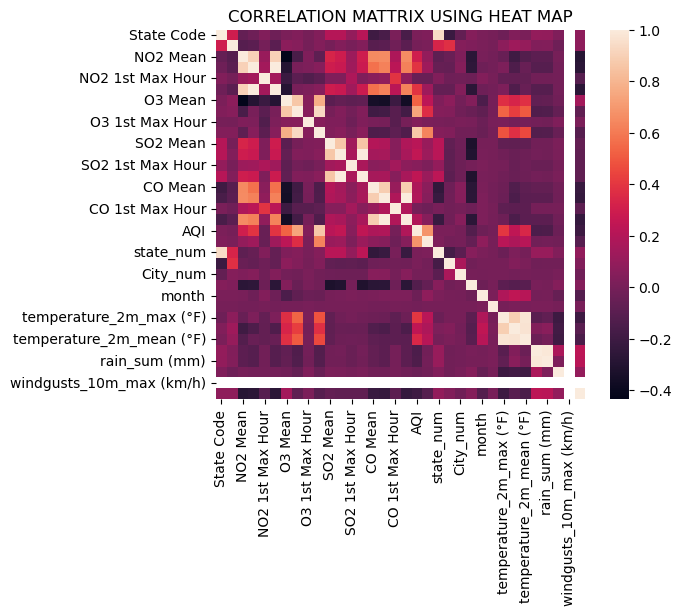

In [9]:
sns.heatmap(corr_matrix, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title("CORRELATION MATTRIX USING HEAT MAP")
plt.show()

<h4>After Studying the heatmap and Correlation Matrix, we have selected 'Date Local','State Code','County Code','NO2 Mean','NO2 AQI','O3 Mean','O3 AQI','SO2 Mean','SO2 AQI', 'CO Mean','CO AQI','precipitation_sum (mm)','rain_sum (mm)','snowfall_sum (cm)','temperature_2m_mean (°F)','windspeed_10m_max (km/h)','AQI' features for our model. Using selected features will reduce multi-collinearity

In [10]:
# cal = data[['Date Local','State Code','County Code','CO Mean','CO 1st Max Value','CO 1st Max Hour','CO AQI',]]
cal = cal[['Date Local','State Code','County Code','NO2 Mean','NO2 AQI','O3 Mean','O3 AQI','SO2 Mean','SO2 AQI',
            'CO Mean','CO AQI','precipitation_sum (mm)','rain_sum (mm)','snowfall_sum (cm)','temperature_2m_mean (°F)','windspeed_10m_max (km/h)','AQI']]
cal = cal.set_index('Date Local')
cal.shape

(3758, 16)

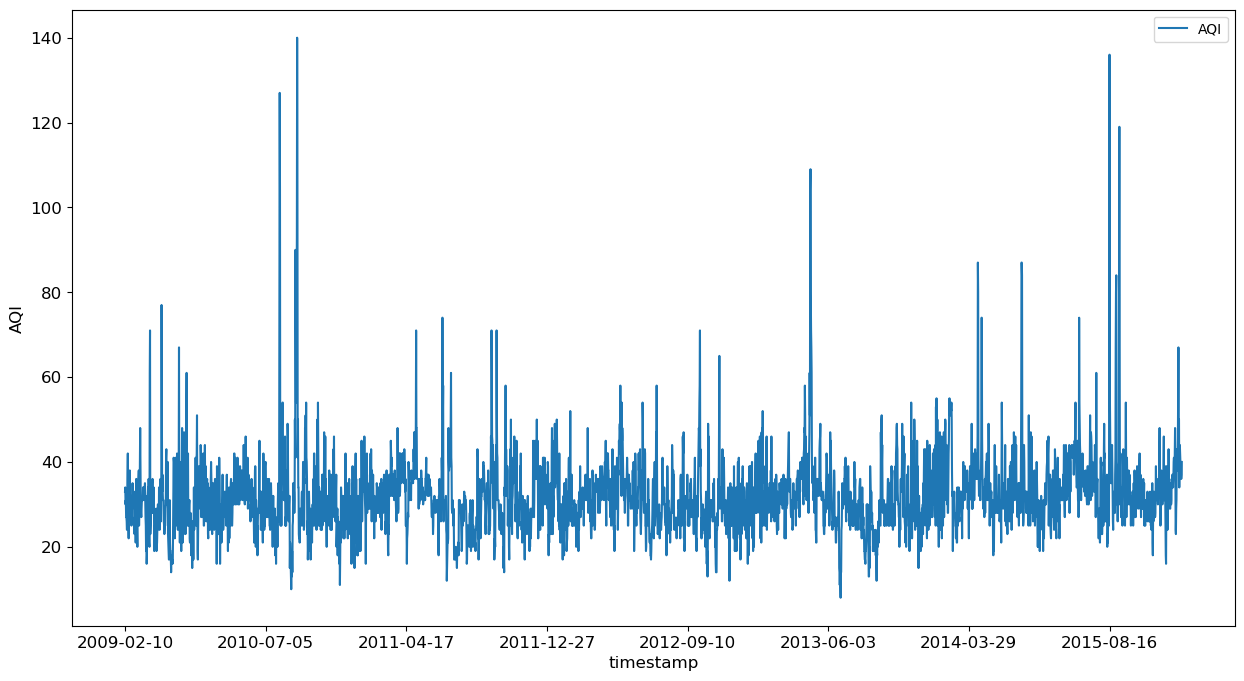

In [11]:
cal.plot(y='AQI', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.show()

The above plot shows the AQI levels over time

In [12]:
train_start_dt = '2000-01-01'
test_start_dt = '2014-01-01'

<h4>Splitting time series data chronologically into train and test sets is an essential step in time series analysis and forecasting. Here are some reasons why it's important:<br>
    Avoiding data leakage: Time series data has a natural temporal order, and future observations are highly correlated with past observations. As a result, it's crucial to avoid data leakage when building a model. By splitting the data into a training set that comes before the test set, we can ensure that our model is only trained on past data and not influenced by future observations.

Evaluating model performance: When building a time series model, we need to evaluate its performance on unseen data to ensure that it can generalize to new observations. By splitting the data into a training set and a test set, we can evaluate the model's performance on the test set and get an accurate estimate of its ability to make predictions on future data.

Tuning model parameters: When building a time series model, we often need to tune its parameters to improve its performance. By splitting the data into a training set and a validation set, we can tune the model parameters on the validation set and evaluate its performance on the test set to get an accurate estimate of how well it will perform on unseen data.

Overall, splitting time series data chronologically into train and test sets is a best practice in time series analysis and forecasting, and it can help us avoid data leakage, evaluate model performance, and tune model parameters to improve its predictions.

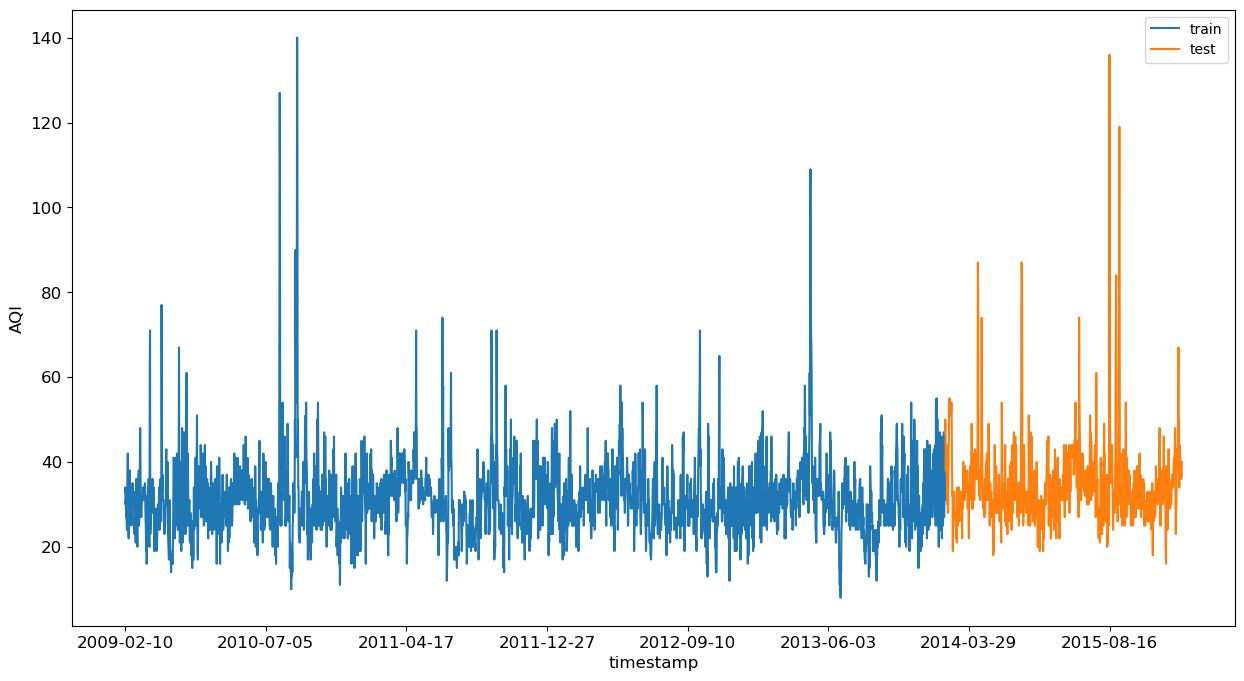

In [13]:
cal[(cal.index < test_start_dt) & (cal.index >= train_start_dt)][['AQI']].rename(columns={'AQI':'train'}) \
    .join(cal[test_start_dt:][['AQI']].rename(columns={'AQI':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.show()

In [14]:
train = cal.copy()[(cal.index >= train_start_dt) & (cal.index < test_start_dt)][['State Code','County Code','NO2 Mean','NO2 AQI','O3 Mean','O3 AQI','SO2 Mean','SO2 AQI',
            'CO Mean','CO AQI','precipitation_sum (mm)','rain_sum (mm)','snowfall_sum (cm)','temperature_2m_mean (°F)','windspeed_10m_max (km/h)','AQI']]
test = cal.copy()[cal.index >= test_start_dt][['State Code','County Code','NO2 Mean','NO2 AQI','O3 Mean','O3 AQI','SO2 Mean','SO2 AQI',
            'CO Mean','CO AQI','precipitation_sum (mm)','rain_sum (mm)','snowfall_sum (cm)','temperature_2m_mean (°F)','windspeed_10m_max (km/h)','AQI']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (2915, 16)
Test data shape:  (843, 16)


In [15]:
x_train = train[['State Code','County Code','NO2 Mean','NO2 AQI','O3 Mean','O3 AQI','SO2 Mean','SO2 AQI',
            'CO Mean','CO AQI','precipitation_sum (mm)','rain_sum (mm)','snowfall_sum (cm)','temperature_2m_mean (°F)','windspeed_10m_max (km/h)']].values
y_train = train[['AQI']].values

x_test = test[['State Code','County Code','NO2 Mean','NO2 AQI','O3 Mean','O3 AQI','SO2 Mean','SO2 AQI',
            'CO Mean','CO AQI','precipitation_sum (mm)','rain_sum (mm)','snowfall_sum (cm)','temperature_2m_mean (°F)','windspeed_10m_max (km/h)']].values
y_test = test[['AQI']].values

In [16]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [17]:
y_train = y_train.ravel()
y_test = y_test.ravel()

Support Vector Regression (SVR) is a popular machine learning algorithm for time series forecasting because it can handle non-linear relationships between variables and can capture complex patterns in the data. Here are some reasons why SVR performs well in time series data:

Non-linear relationships: Time series data often exhibits non-linear relationships between variables, and linear regression models may not be able to capture these complex relationships. SVR, on the other hand, uses a non-linear kernel function to transform the data into a higher-dimensional space, where it can capture non-linear relationships between the variables.

Robustness to outliers: Time series data can be noisy and contain outliers, which can affect the performance of linear regression models. SVR is more robust to outliers because it focuses on minimizing the margin of error instead of minimizing the sum of squared errors.

Flexibility: SVR can be used with different types of kernel functions, such as linear, polynomial, and radial basis function (RBF), which can capture different types of patterns in the data. This flexibility makes SVR suitable for a wide range of time series forecasting tasks.

Handling high-dimensional data: Time series data can have a high number of features, which can make it challenging to build accurate models. SVR can handle high-dimensional data by projecting it into a higher-dimensional space using the kernel function, where it can capture complex relationships between the variables.

Overall, SVR is a powerful algorithm for time series forecasting because it can handle non-linear relationships, is robust to outliers, is flexible, and can handle high-dimensional data. However, like any machine learning algorithm, its performance depends on the quality of the data, the choice of kernel function, and the tuning of its parameters.

In [18]:
model = SVR(kernel='rbf',gamma=0.1, C=1000, epsilon = 0.05)
model.fit(x_train, y_train)

SVR(C=1000, epsilon=0.05, gamma=0.1)

In [19]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(2915, 1) (843, 1)


<h2>Verifying performance on Test dataset

In [20]:
score = r2_score(y_test,y_test_pred)
mean_error = mean_squared_error(y_test,y_test_pred)
mae = mean_absolute_error(y_test,y_test_pred)
print("R2 SCORE is", score)
print("mean_sqrd_error is ", mean_error)
print("Root mean squared error of is",np.sqrt(mean_error))
print("Mean Absolute error is", mae)

R2 SCORE is 0.9822775031392404
mean_sqrd_error is  1.8329241291516987
Root mean squared error of is 1.3538552836812725
Mean Absolute error is 0.9574609038132135


<h2>Comparing Actual vs Predicted data

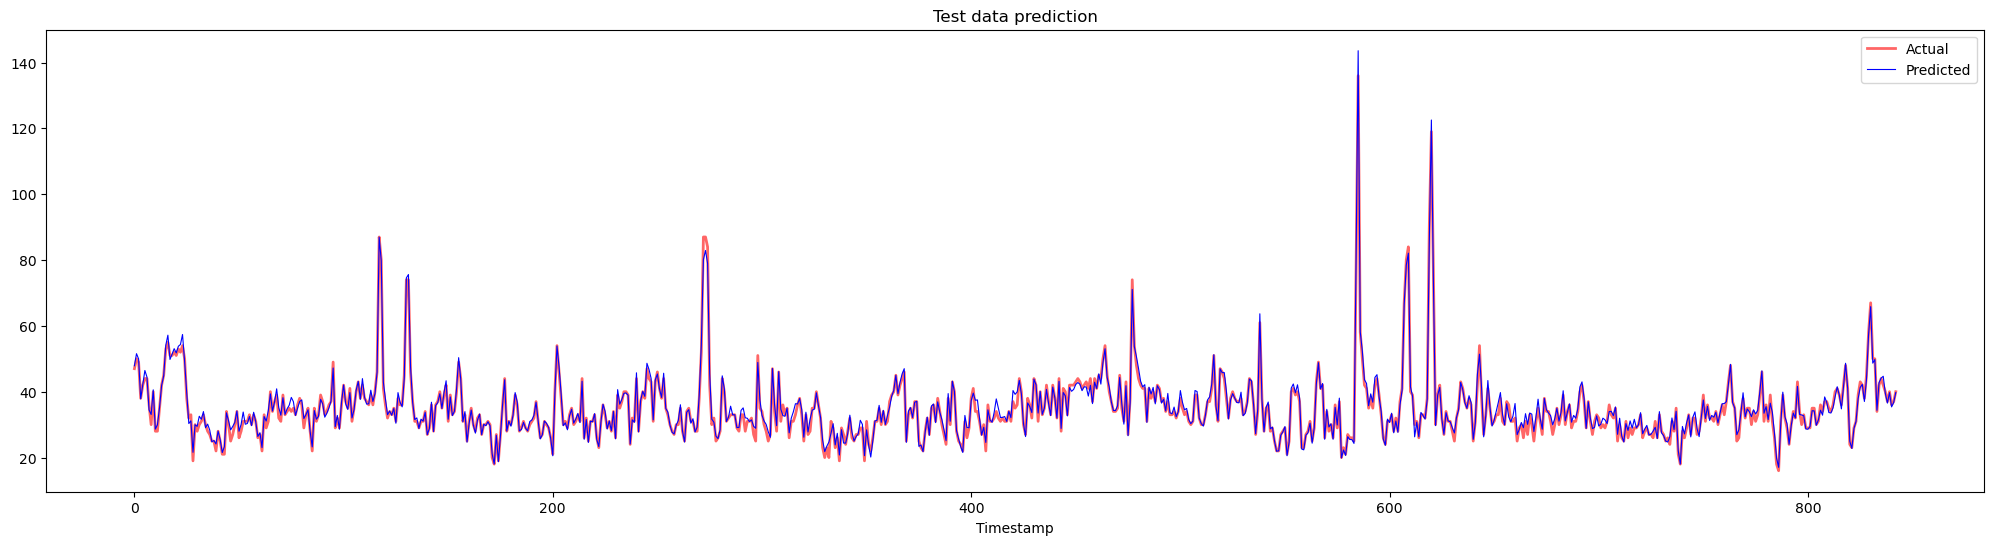

In [21]:
plt.figure(figsize=(25,6))
plt.plot(y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Test data prediction")
plt.show()